## 제출용 (final 기준)

한줄요약: 데이터 가공위주로 진행

In [ ]:
# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pre-processing Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/competition_1st/train.csv')

In [ ]:
def pre_proc_data(my_df):
    #####-----------------새로운 컬럼 먼저생성-----------------#####
    my_df['my_ft1'] = my_df['int_rate']*my_df['dti']
    my_df['my_ft2'] = np.log(my_df['annual_inc']*my_df['fico_range_low'])
    my_df['my_ft4'] = my_df['int_rate']*my_df['funded_amnt']
    my_df['my_ft5'] = my_df['int_rate']*my_df['dti']/np.log(df['tot_cur_bal']*my_df['fico_range_low'])
    my_df['my_ft6'] = my_df['revol_util']/(my_df['revol_bal']+0.0000001)
    my_df['my_ft7'] = my_df['int_rate']*my_df['funded_amnt']/np.log(my_df['tot_cur_bal']*my_df['fico_range_low']+2)
    my_df['my_ft9'] = np.log(my_df['int_rate']*my_df['funded_amnt'])*my_df['dti']
    my_df['my_ft11'] = my_df['installment']/ my_df['annual_inc']
    my_df['my_ft14'] = my_df['total_rec_int']/my_df['installment']
    my_df['my_ft15'] = my_df['delinq_2yrs']+2*my_df['pub_rec']+3*my_df['inq_last_6mths']
    my_df['my_ft17'] = (2-(1+np.log(1+my_df['term1'])+0.0001)*np.log(1+my_df['term1'])/(np.log(1+my_df['term1'])+0.0001)
                      +2*((1+np.sqrt(np.log(1+my_df['total_rec_late_fee']+0.0001)))*np.log(1+my_df['total_rec_late_fee'])/(np.log(1+my_df['total_rec_late_fee'])+0.0001))
                      +(1+1/5*(np.log(1+my_df['collections_12_mths_ex_med'])))*np.log(1+my_df['collections_12_mths_ex_med'])/(np.log(1+my_df['collections_12_mths_ex_med'])+0.0001)
                    )
    my_df['my_ft18'] = (0.9*(1+np.sqrt(np.log(1+my_df['home_ownership6'])))*np.log(1+my_df['home_ownership6'])/(np.log(1+my_df['home_ownership6'])+0.0001)
                          +(1+np.log(1+my_df['verification_status3']))*np.log(1+my_df['verification_status3'])/(np.log(1+my_df['verification_status3'])+0.0001)
                          +0.5*(1+np.log(1+my_df['initial_list_status1']))*np.log(1+my_df['initial_list_status1'])/(np.log(1+my_df['initial_list_status1'])+0.0001))
    col_list = list(my_df.columns)
    col_list[15:27]
    emp_list0 = col_list[16:26]
    emp_list1 = col_list[15:16]
    emp_list2 = col_list[26:27]
    my_df['my_ft29'] = int(0)
    for col in emp_list1:
        my_df['my_ft29'] += my_df[col]
    for col in emp_list2:
        my_df['my_ft29'] += 2*my_df[col]
    msld_list = col_list[52:63]
    my_df['my_ft30'] = int(0)
    for col in msld_list[1:]:
        my_df['my_ft30'] += my_df[col]
    #####-----------------불필요한 컬럼 삭제-----------------#####
    my_df.drop(['out_prncp_inv', 'funded_amnt_inv', 'purpose4', 'fico_range_high', 'acc_now_delinq'], axis=1, inplace=True)
    my_df.drop(['total_acc'], axis=1, inplace=True)
    my_df.drop(['emp_length1','emp_length2',  'emp_length3', 'emp_length4',
                'emp_length5', 'emp_length6', 'emp_length7', 'emp_length8',
                'emp_length9', 'emp_length10', 'emp_length11', 'emp_length12'
                ], axis=1, inplace=True)
    my_df.drop(['mths_since_last_delinq1','mths_since_last_delinq2',  'mths_since_last_delinq3', 'mths_since_last_delinq4',
                'mths_since_last_delinq5', 'mths_since_last_delinq6', 'mths_since_last_delinq7', 'mths_since_last_delinq8',
                'mths_since_last_delinq9', 'mths_since_last_delinq10', 'mths_since_last_delinq11'
                ], axis=1, inplace=True)
    my_df.drop(['home_ownership1',  'home_ownership3', 'home_ownership4',
                ], axis=1, inplace=True)
    my_df.drop(['purpose11',  'purpose14',
                ], axis=1, inplace=True)

# public 높은것과 final 높은것 차이점 : public은 my_ft30을 제외, ft30같은 경우 feature정보를 뭉뚱그려줘서 정확도는 떨어지지만 overfitting 영향이 덜함

In [ ]:
# 전처리 진행
pre_proc_data(df)

#### 컬럼 삭제 설명

In [ ]:
'''
out_prncp_inv = out_prncp와 완전 동일
purpose4는 train과 test 둘 다 값 없음
funded_amnt_inv는 funded_amnt와 유의미한 차이가 안보임
fico_range_high는 low와 유사하고 채무불이행에는 low가 논리적으로 더 중요하다고 생각. ft_imp도 0에 가까워서 제외
chargeoff 는 1:2비율에 숫자도 10만개중 850개정도
acc_now_delinq는 유의미 데이터가 10개단위임
'''
# df=df.drop(['out_prncp_inv', 'funded_amnt_inv', 'purpose4', 'fico_range_high','chargeoff_within_12_mths', 'acc_now_delinq'], axis=1)


'''total_acc 는 정확히 모든 구간이 1:2 비율, 다른 컬럼과 연계를 해야 의미가 생기는데, 연계되는 컬럼이 안보여서 제외'''
# df=df.drop(['total_acc', 'initial_list_status2'], axis=1)

''' my_ft29, my_ft30 생성으로 의미없어진 컬럼 삭제 '''
# my_df.drop(['emp_length1','emp_length2',  'emp_length3', 'emp_length4',
#                 'emp_length5', 'emp_length6', 'emp_length7', 'emp_length8',
#                 'emp_length9', 'emp_length10', 'emp_length11', 'emp_length12'
#                 ], axis=1, inplace=True)
# df=df.drop(['mths_since_last_delinq1',  'mths_since_last_delinq2', 'mths_since_last_delinq3',
#             'mths_since_last_delinq4', 'mths_since_last_delinq5', 'mths_since_last_delinq6',
#             'mths_since_last_delinq7', 'mths_since_last_delinq8', 'mths_since_last_delinq9',
#             'mths_since_last_delinq10'], axis=1)

'''home ownership1,3,4 는 100개 이하 존재, feature importance 0'''
'''purpose11,14는 ft_imp = 0 '''

# my_df.drop(['home_ownership1',  'home_ownership3', 'home_ownership4',
#             ], axis=1, inplace=True)
# my_df.drop(['purpose11',  'purpose14',
#             ], axis=1, inplace=True)

## Train - Valid set 분리 (상황에 맞게 비율 조절, ex-제출용은 99%로 학습)

In [ ]:
X = df.drop('depvar', axis=1)
y = df['depvar']

# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

## 정규화 
tree기반 machine learning에서는 의미없음

In [ ]:
# 정규화 // 오히려 정규화하고 점수 더 안좋아지는 경향

X_train_sc = StandardScaler().fit_transform(X_train)
X_valid_sc = StandardScaler().fit_transform(X_valid)

## SMOTE
데이터 증강 -> 오히려 학습방해, 사용안함

In [ ]:
# Data 증축 전, 결과 값 비율
print("Before OverSampling, counts of label '0': {}".format(sum(y_train==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))

Before OverSampling, counts of label '0': 67368
Before OverSampling, counts of label '1': 32532


In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42) 
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))

After OverSampling, counts of label '0': 67368
After OverSampling, counts of label '1': 67368


## 사용할 평가 함수 정의

In [ ]:
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))

In [ ]:
def get_clf_eval2(y_actual, y_pred):    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

## 하이퍼 파라미터 최적화

In [ ]:
# 1. Random Forest
rnd_clf = RandomForestClassifier(random_state=42)

param_grid = { 'n_estimators' : [250],
           'max_depth' : [16],          #[16~18] -> 16
           'min_samples_leaf' : [8],    # [8~18] -> 8
           'min_samples_split' : [30]   # [8~30] -> 20
            }

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
grid_search = GridSearchCV(estimator=rnd_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv) 

results_rnd=grid_search.fit(X_train, y_train)
results_rnd.best_params_

{'max_depth': 16,
 'min_samples_leaf': 8,
 'min_samples_split': 20,
 'n_estimators': 250}

In [ ]:
# Random Forest best parameter를 사용하여 prediction 수행
rdn_clf = RandomForestClassifier(max_depth = 16,
                                n_estimators = 250,
                                min_samples_leaf=8,
                                min_samples_split=20,
                                ) 
rdn_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, min_samples_leaf=8, min_samples_split=20,
                       n_estimators=250)

In [ ]:
# Random Forest 평가점수
threshold_list = [0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44]
for i in threshold_list:
    get_clf_eval(y_valid, rdn_clf.predict_proba(X_valid)[:,1]> i)

In [ ]:
# 2. XGBoost
xgb_clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor',
                        objective='binary:logistic', nthread=-1,
                        random_state=42)

param_grid = {'max_depth':[6],              # [5~10] -> 6
              'n_estimators':[200]          # [150~350]-> 200
              }

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid, 
                          #  n_jobs=-1,
                           cv=cv,
                           scoring='roc_auc', 
                           error_score=0) 

results_xgb=grid_search.fit(X_train, y_train)
results_xgb.best_params_

{'max_depth': 6, 'n_estimators': 200}

In [ ]:
# XGB best parameter를 사용하여 prediction 수행
xgb_clf = XGBClassifier(max_depth = results_xgb.best_params_['max_depth'],
                        n_estimators = 200,
                        eval_metric='logloss', predictor='gpu_predictor',
                        objective='binary:logistic', nthread=-1,
                        random_state=42) 

xgb_clf.fit(X_train, y_train)

XGBClassifier(eval_metric='logloss', max_depth=6, n_estimators=200, nthread=-1,
              predictor='gpu_predictor', random_state=42)

In [ ]:
# XGB 평가점수
threshold_list = [0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44]
for i in threshold_list:
    get_clf_eval(y_valid, xgb_clf.predict_proba(X_valid)[:,1]> i)

In [ ]:
# 3. Light GBM
lgbm_clf = LGBMClassifier()

param_grid = {'max_depth':[13],     #[5~17] -> 13
              'n_estimators':[280]  #[100~300] -> 280
              }

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
grid_search = GridSearchCV(estimator=lgbm_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='roc_auc', 
                           error_score=0) 

results_lgbm = grid_search.fit(X_train, y_train)
results_lgbm.best_params_

In [ ]:
# LGBM best parameter를 사용하여 prediction 수행
lgbm_clf = LGBMClassifier(max_depth = results_lgbm.best_params_['max_depth'],
                                n_estimators = results_lgbm.best_params_['n_estimators'],
                                eval_metric='logloss', random_state=42)

lgbm_clf.fit(X_train, y_train)

LGBMClassifier(eval_metric='logloss', max_depth=15, n_estimators=280,
               random_state=42)

In [ ]:
# LGBM 평가점수
threshold_list = [0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44]
for i in threshold_list:
    get_clf_eval(y_valid, lgbm_clf.predict_proba(X_valid)[:,1]> i)

## 각 classifier의 feature 중요도
-새로만든 컬럼이 score상승에 의미가 있는지 판단

In [ ]:
# Feature 중요도 구하기
def feat_importance(model, df):
    return pd.DataFrame({'cols':df.columns, 'imp':model.feature_importances_}).sort_values('imp', ascending=False)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.001, random_state=42)

In [ ]:
rnd_clf = RandomForestClassifier(max_depth=16, n_estimators=250, random_state=42, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, n_estimators=250, n_jobs=-1,
                       random_state=42)

In [ ]:
rnd_fi = feat_importance(rnd_clf, df.drop(columns=['depvar']))
# Feature importance 시각화
idx = np.arange(len(rnd_fi.cols))
plt.figure(figsize=(12, 22))
plt.barh(idx, rnd_fi.imp, align='center')
plt.yticks(idx, rnd_fi.cols)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

In [ ]:
lgbm_clf = LGBMClassifier(max_depth=6, n_estimators=200, random_state=42)
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(max_depth=6, n_estimators=200, random_state=42)

In [ ]:
lgbm_fi = feat_importance(lgbm_clf, df.drop(columns=['depvar']))
# Feature importance 시각화
idx = np.arange(len(lgbm_fi.cols))
plt.figure(figsize=(12, 22))
plt.barh(idx, lgbm_fi.imp, align='center')
plt.yticks(idx, lgbm_fi.cols)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

In [ ]:
xgb_clf = XGBClassifier(max_depth=7, n_estimators=250, 
                        objective='binary:logistic', nthread=-1,
                        random_state=42, tree_method='gpu_hist', predictor='gpu_predictor')
xgb_clf.fit(X_train, y_train, eval_metric='logloss')

XGBClassifier(max_depth=7, n_estimators=250, nthread=-1,
              predictor='gpu_predictor', random_state=42,
              tree_method='gpu_hist')

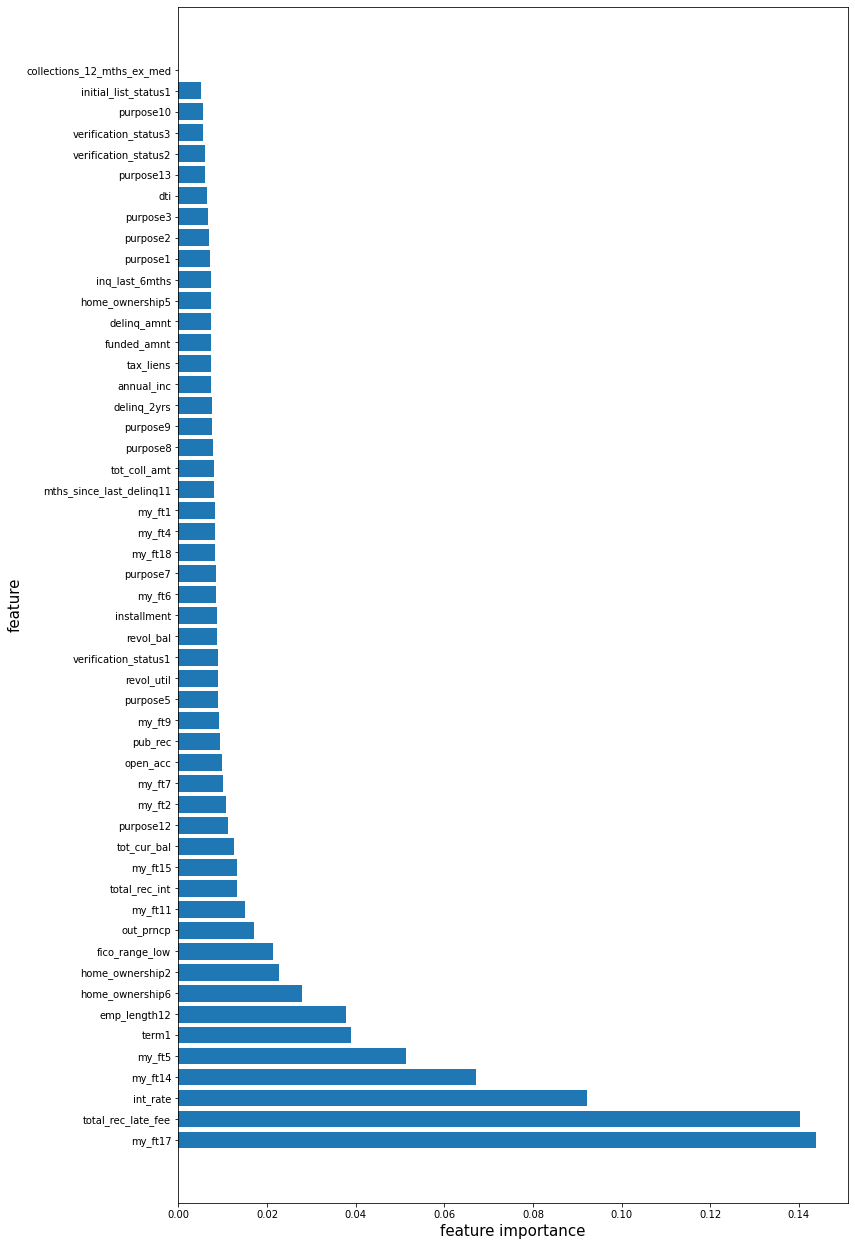

In [ ]:
xgb_fi = feat_importance(xgb_clf, df.drop(columns=['depvar']))
# Feature importance 시각화
idx = np.arange(len(xgb_fi.cols))
plt.figure(figsize=(12, 22))
plt.barh(idx, xgb_fi.imp, align='center')
plt.yticks(idx, xgb_fi.cols)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

Feature 갯수에 따른 accuracy 확인

In [ ]:
min_features_to_select = 20
rfecv = RFECV(
    estimator=xgb_clf,  #xgb
    step=1,
    cv=StratifiedKFold(2),
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("최적 feature 갯수 : %d" % rfecv.n_features_)

plt.figure()
plt.xlabel("feature 수")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [ ]:
min_features_to_select = 20
rfecv = RFECV(
    estimator=lgbm_clf, #lgbm
    step=1,
    cv=StratifiedKFold(2),
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

## 앙상블 fitting

In [ ]:
# 최적화 한걸로 ensemble 진행
rnd_clf = RandomForestClassifier(max_depth = 16,
                                n_estimators = 250,
                                min_samples_leaf=8,
                                min_samples_split=20)

lgbm_clf =  LGBMClassifier(max_depth=15, num_leaves = int(0.7*2**(15)), n_estimators=280, objective='binary', random_state=42)

xgb_clf = XGBClassifier(max_depth=6, n_estimators=200, random_state=42,
                        objective='binary:logistic',
                        tree_method='gpu_hist', predictor='gpu_predictor')

xgb_clf2 = XGBClassifier(max_depth=12, objective='binary:logistic',
                        tree_method='gpu_hist', predictor='gpu_predictor', random_state=42)

stacking_clf = StackingClassifier(estimators = [ ('lgbm', lgbm_clf), ('xgb', xgb_clf)
                                                ,('rnd', rnd_clf)
                                                ,('xgb2', xgb_clf2)
                                                ],
                                  cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                  final_estimator = LGBMClassifier(objective='binary',random_state=42))

stacking_clf.fit(X_train, y_train)

## Test / Train 비율 조절

In [ ]:
X = df.drop('depvar', axis=1)
y = df['depvar']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X = df.drop('depvar', axis=1)
y = df['depvar']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.001, random_state=42)

In [ ]:
X = df.drop('depvar', axis=1)
y = df['depvar']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.36, random_state=42)

## validation 진행

In [ ]:
threshold_list = [0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40]
for i in threshold_list:
    get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]> i)


heatmap_list = [0.38]
for i in heatmap_list:
    get_clf_eval2(y_valid, stacking_clf.predict_proba(X_valid)[:,1]> i)

## 제출

In [ ]:
def submission(df, sub, th):
    threshold = th
    submit = sub
    submit['answer'] = stacking_clf.predict_proba(df_test.drop(columns=['ID']))[:,1]> threshold
    change = {True:1, False:0}
    submit.answer = submit.answer.map(change)
    return submit

In [ ]:
# 제출 양식 다운로드
df_test = pd.read_csv('/content/drive/MyDrive/competition_1st/test.csv')
submit = pd.read_csv('/content/drive/MyDrive/competition_1st/sample_submission.csv')

# test파일에도 위에서 했던 전처리 진행
pre_proc_data(df_test)

# 제출 답안 작성 (predict)
submit = submission(df_test, submit, 0.39)

In [ ]:
submit.answer.value_counts()

0    21343
1    14473
Name: answer, dtype: int64

In [ ]:
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/competition_1st/submission_X.csv', index=False)